Tracker code for TrackLife Project 02712 Modeling and Simulation

In [12]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

data_dir = "/Users/jonathanzhu/Documents/data/MI"
os.chdir(data_dir)

## Testing Different Methods

In [74]:
#data directory
#FOR COLLABORATORS: DATA IS NOT IN GITHUB AND IS STORED IN A SEPARATE DIRECTORY
#you can change this to your directory to run stuff if needed
#data_dir = "~/Users/jonathanzhu/Documents/data/MI"

#for i from 1 to 8, we have a folder named MI0i, such as MIO1, MI02, etc.
#each folder has a sub-folder named images
#for each image in images, we want to do boundary detection and get the midpoint of the boundary regions,
#corresponding to the center of each cell.

#Helper function: For one image, get the boundary regions and the midpoints of the boundary regions
def get_boundary_midpoint(image_path, lower_threshold = 127, upper_threshold = 255):
    #read the image
    img = cv2.imread(image_path, 0)
    #get the boundary regions
    boundary = get_boundary(img, lower_threshold, upper_threshold)
    #get the midpoints of the boundary regions
    midpoints = get_midpoints(boundary)
    return boundary, midpoints

#Helper function: For one image, get the boundary regions
def get_boundary(img, lower_threshold, upper_threshold):
    blur = cv2.GaussianBlur(img, (5,5), 0)
    #threshold the image
    ret,thresh1 = cv2.threshold(blur,lower_threshold, upper_threshold ,cv2.THRESH_BINARY)
    #find contours
    contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #get the boundary regions
    boundary = []
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        boundary.append((x,y,w,h))
    return boundary

#Helper function: For one image, get the midpoints of the boundary regions
def get_midpoints(boundary):
    midpoints = []
    for x,y,w,h in boundary:
        midpoints.append((x+w//2, y+h//2))
    return midpoints

#helper function: edge detection
#using a simple 3x3 kernel for edge detection
def edge_detection(img, kernel = np.array([[1,1,1],[1,-8,1],[1,1,1]])):
    #for every 3x3 region, element-wise multiplication with the kernel
    #and sum the results to get the edge detection result
    edge = np.zeros_like(img)
    for i in range(1, img.shape[0]-1):
        for j in range(1, img.shape[1]-1):
            edge[i,j] = np.sum(img[i-1:i+2, j-1:j+2]*kernel)
    return edge

#helper function: plot the boundary regions and midpoints
def plot_boundary_midpoint(img, boundary, midpoints):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    for x,y,w,h in boundary:
        rect = plt.Rectangle((x, y), w, h, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    for x,y in midpoints:
        ax.scatter(x, y, c='r', s=10)
    plt.show()

def add_midpoints(img, midpoints, n = 10):
    #make a combined image with the midpoints
    img_midpoints = img.copy()
    for x,y in midpoints:
        #in a nxn region around the midpoint, set the pixel values to 255
        #to make the midpoint more visible
        img_midpoints[y-n:y+n, x-n:x+n] = 255
    return img_midpoints

First we test an image on `cv2.threshold` and `cv2.findContours` to see how well it performs at bounding the cells and finding their midpoints.

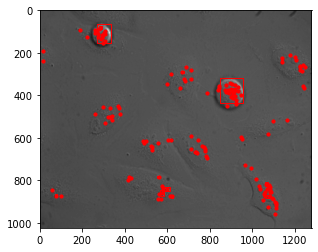

In [65]:
#CV2 results with cv2.findContours
img = mpimg.imread("MI01/images/I_MI01_0001.png")
#plot the boundary regions and midpoints
boundary, midpoints = get_boundary_midpoint("MI01/images/I_MI01_0001.png", lower_threshold=100)
plot_boundary_midpoint(img, boundary, midpoints)

Not very well, so we turn to a classic edge detection self-implemented without using `cv2`, where we use a detection kernel.

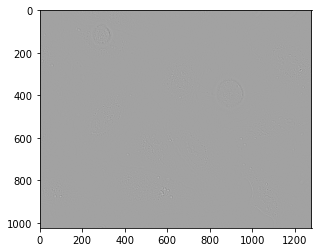

In [23]:
#plotting boundary results with the matplotlib contour function
img = mpimg.imread("MI01/images/I_MI01_0001.png")

edges = edge_detection(img)
#plot the edges
plt.imshow(edges, cmap='gray')

YEAH SO OBVIOUSLY THIS PERFORMS EVEN WORSE. Maybe if we try different kernels? We previously used the standard kernel of -8 surrounded by 1. Let's try a more complex method, the Sobel operator to get two entries for each point. 

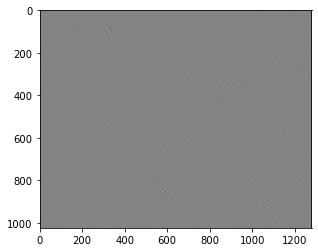

In [24]:
#use the Sobel operator for edge detection
edges_sobel = cv2.Sobel(img, cv2.CV_64F, 1, 1, ksize=5)
plt.imshow(edges_sobel, cmap='gray')

Okay, let's try something else since that worked so great. Let's do a complex method called the Canny edge detection algorithm that relies on gradients.

In [30]:
#use the Canny edge detection algorithm
def canny_edge_detection(img, low_threshold = 100, high_threshold = 200):
    #want to not use cv2.Canny, but implement the algorithm ourselves
    #1. apply Gaussian filter to smooth the image
    #for every pixel, apply a 5x5 Gaussian filter with sigma = 1.4
    smooth_img = cv2.GaussianBlur(img, (5,5), 1.4)

    #2. find the intensity gradients of the image
    #for every pixel, find gradient magnitude and direction
    #gradient magnitude = sqrt(Gx^2 + Gy^2)
    #gradient direction = arctan(Gy/Gx)
    #Gx and Gy are the gradients in the x and y directions
    #use Sobel operator to find Gx and Gy
    Gx = cv2.Sobel(smooth_img, cv2.CV_64F, 1, 0, ksize=3)
    Gy = cv2.Sobel(smooth_img, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(Gx**2 + Gy**2)
    gradient_direction = np.arctan(Gy/Gx)

    #3. apply non-maximum suppression to get rid of spurious response to edge detection
    #for every pixel, check if it is a local maximum in the direction of the gradient
    #if it is not, set it to 0
    #if it is, keep the value
    suppressed_img = np.zeros_like(gradient_magnitude)
    for i in range(1, suppressed_img.shape[0]-1):
        for j in range(1, suppressed_img.shape[1]-1):
            if gradient_direction[i,j] < np.pi/8 or gradient_direction[i,j] > 7*np.pi/8:
                if gradient_magnitude[i,j] > gradient_magnitude[i,j-1] and gradient_magnitude[i,j] > gradient_magnitude[i,j+1]:
                    suppressed_img[i,j] = gradient_magnitude[i,j]
            elif gradient_direction[i,j] < 3*np.pi/8:
                if gradient_magnitude[i,j] > gradient_magnitude[i-1,j+1] and gradient_magnitude[i,j] > gradient_magnitude[i+1,j-1]:
                    suppressed_img[i,j] = gradient_magnitude[i,j]
            elif gradient_direction[i,j] < 5*np.pi/8:
                if gradient_magnitude[i,j] > gradient_magnitude[i-1,j] and gradient_magnitude[i,j] > gradient_magnitude[i+1,j]:
                    suppressed_img[i,j] = gradient_magnitude[i,j]
            else:
                if gradient_magnitude[i,j] > gradient_magnitude[i-1,j-1] and gradient_magnitude[i,j] > gradient_magnitude[i+1,j+1]:
                    suppressed_img[i,j] = gradient_magnitude[i,j]

    #4. apply double threshold to determine potential edges
    #if the pixel value is above the high threshold, it is an edge
    #if the pixel value is below the low threshold, it is not an edge
    #if the pixel value is between the two thresholds, it is a weak edge
    edges = np.zeros_like(suppressed_img)
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if suppressed_img[i,j] > high_threshold:
                edges[i,j] = 255
            elif suppressed_img[i,j] < low_threshold:
                edges[i,j] = 0
            else:
                edges[i,j] = 128
                
    return edges
    

/var/folders/px/b7vc3nh913zb_m0x36ncftj00000gn/T/ipykernel_17995/2337255044.py:17: RuntimeWarning: divide by zero encountered in divide
  gradient_direction = np.arctan(Gy/Gx)
/var/folders/px/b7vc3nh913zb_m0x36ncftj00000gn/T/ipykernel_17995/2337255044.py:17: RuntimeWarning: invalid value encountered in divide
  gradient_direction = np.arctan(Gy/Gx)


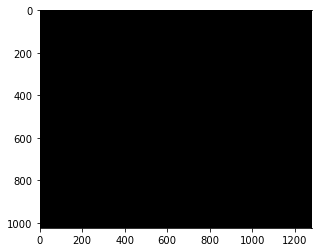

In [31]:
edges = canny_edge_detection(img)
plt.imshow(edges, cmap='gray')

That didn't work according to plan. Let's try a well-known tracker algo, watershed.

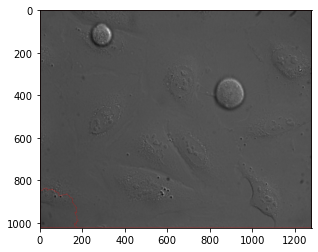

In [51]:
#watershed time
#use the watershed algorithm to segment the image
#this relies on Otsu's binarization to get the markers
#and then uses the watershed algorithm to segment the image
img = cv2.imread("MI01/images/I_MI01_0001.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#apply gaussian blur to smooth the image
blur = cv2.GaussianBlur(gray, (5,5), 0)

ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

#noise removal
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)

#sure background area
sure_bg = cv2.dilate(opening, kernel, iterations = 3)

#finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

#finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

#marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

markers = cv2.watershed(img, markers)
img[markers == -1] = [255,0,0]

plt.imshow(img)

Unfortunately, it seems that the problem of these images is that there does not exist enough capability to binarize the cells that are present in each image, so a proper mask cannot be generated with existing methods, regardless of what we try. Watershed generated a completely wrong thing for this in the form of an incorrect boundary on something that does not remotely resemble a cell. 

However, I have an idea: the first function we tested of finding midpoints of cells seemed to work relatively well at pointing to cells. If we were to cluster these, we could make "masks" of cells in each image, which are easier to binarize and thus can be more easily used in watershed. 

This makes a problem as we have a bunch of points on a graph and we want to cluster them into an optimal amount of clusters. This is untractable, especially as we do not know the correct number of clusters. How would we go about solving this problem? 

A heuristic method that relies on the image resolution and the cell size is to know that cells follow certain dimensions. By applying a certain dimensionaility to contain the midpoints that we get, we can heuristically get a smoothened mask on which to apply watershed.

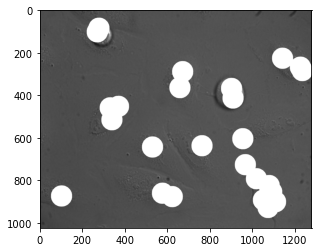

In [98]:
img = cv2.imread("MI01/images/I_MI01_0001.png")

#heuristic for segmentation: for each midpoint, get the region around it
#the way we can do this is to take advantage of cell dimension; they are roughly circular
#by choosing k points to be the center of a circle of some radius r, we can get a region in which all other points are going to be in the same cell
#we can then use this region to segment the image

def pick_random_indices(m, n):
    #pick m random indices from 0 to n-1
    return np.random.choice(n, m, replace=False)

def apply_circles(img, midpoints, r = 20, k = 10):
    #apply circles around the midpoints
    img_circles = img.copy()

    #predetermined indices
    indices = pick_random_indices(k, len(midpoints))
    for i in indices:
        x1,y1 = midpoints[i]
        #draw a circle with center (x1,y1) and radius r
        cv2.circle(img_circles, (x1,y1), r, (255,255,255), 1)
        #fill the circle
        cv2.circle(img_circles, (x1,y1), r, (255,255,255), -1)
    return img_circles

boundary, midpoints = get_boundary_midpoint("MI01/images/I_MI01_0001.png", lower_threshold=100)
img_circles = apply_circles(img, midpoints, r = 50, k = 25)
plt.imshow(img_circles)

This method provides a decent, fast heuristic method to identify cells in an image and make a mask that approximates their location. 

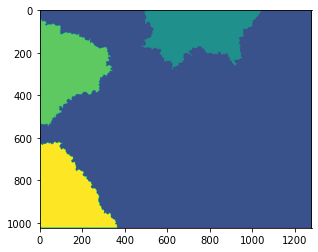

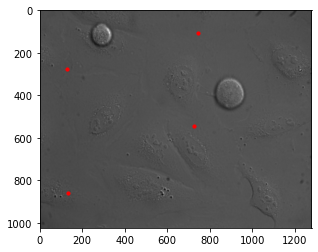

In [88]:
mask = cv2.imread("MI01/Masks/M_MI01_0001.png")
#apply watershed algorithm
gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
#blur = cv2.GaussianBlur(gray, (5,5), 0)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 2)
sure_bg = cv2.dilate(opening, kernel, iterations = 3)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0
markers = cv2.watershed(img, markers)
markers[markers == -1] = 0

#plot markers
plt.imshow(markers)

#find the center of mass of each segment
centers = []
for i in range(1, markers.max()+1):
    x,y = np.where(markers == i)
    centers.append((np.mean(x), np.mean(y)))

#plot results
fig, ax = plt.subplots()
ax.imshow(img)
for x,y in centers:
    ax.scatter(y, x, c='r', s=10)
plt.show()